In [59]:
import pandas as pd

df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [60]:
df.shape
df.info()
df.isnull().sum()
df['type'].value_counts()
df['duration'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


array(['90 min', '2 Seasons', '1 Season', '91 min', '125 min',
       '9 Seasons', '104 min', '127 min', '4 Seasons', '67 min', '94 min',
       '5 Seasons', '161 min', '61 min', '166 min', '147 min', '103 min',
       '97 min', '106 min', '111 min', '3 Seasons', '110 min', '105 min',
       '96 min', '124 min', '116 min', '98 min', '23 min', '115 min',
       '122 min', '99 min', '88 min', '100 min', '6 Seasons', '102 min',
       '93 min', '95 min', '85 min', '83 min', '113 min', '13 min',
       '182 min', '48 min', '145 min', '87 min', '92 min', '80 min',
       '117 min', '128 min', '119 min', '143 min', '114 min', '118 min',
       '108 min', '63 min', '121 min', '142 min', '154 min', '120 min',
       '82 min', '109 min', '101 min', '86 min', '229 min', '76 min',
       '89 min', '156 min', '112 min', '107 min', '129 min', '135 min',
       '136 min', '165 min', '150 min', '133 min', '70 min', '84 min',
       '140 min', '78 min', '7 Seasons', '64 min', '59 min', '139 min',
    

In [61]:
df = df.dropna(subset=['duration'])
df['country'] = df['country'].fillna('Unknown')
df['rating'] = df['rating'].fillna('Unknown')
df['description'] = df['description'].fillna('')
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['release_year'] = df['date_added'].dt.year.fillna(0).astype(int)

In [62]:
def check_popularity(row):
    duration = row['duration']

    if isinstance(duration, str):

        if row['type'] == 'TV Show':
            season_str = duration.split()[0]
            if season_str.isdigit() and int(season_str) >= 2:
                return 1
        elif row['type'] == 'Movie':
            if 'min' in duration:
                minutes_str = duration.split()[0]
                if minutes_str.isdigit() and int(minutes_str) >= 120:    
                    return 1
    return 0 

df['is_popular'] = df.apply(check_popularity, axis=1)

In [63]:
def duration_num(row):
    duration = row['duration']

    if isinstance(duration, str):
        num_str = duration.split()[0]
        if num_str.isdigit():
            return int(num_str)
    return 0    

df['duration_num'] = df.apply(duration_num, axis=1)

In [64]:
df['description_length'] = df['description'].apply(len)
df['type_encoded'] = df['type'].map({'Movie': 0, 'TV Show': 1})
df['cast_count'] = df['cast'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)
df['title_length'] = df['title'].apply(len)
genres = ['Drama', 'Comedy', 'Action', 'Documentary', 'Romance', 'Horror']
for genre in genres:
    df[f'genre_{genre}'] = df['listed_in'].apply(lambda x: int(genre in str(x)))

In [65]:
df = pd.get_dummies(df, columns=['rating'], drop_first=True)

In [66]:
feature_cols = [
    'duration_num',
    'description_length',
    'release_year',
    'type_encoded',
    'cast_count',
    'title_length'
] + [col for col in df.columns if col.startswith('rating_')] \
  + [col for col in df.columns if col.startswith('genre_')]


X = df[feature_cols]
y = df['is_popular']

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [68]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [69]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = 42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

lr = LogisticRegression()
lr.fit(X_train_balanced, y_train_balanced)

y_pred = lr.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:", classification_report(y_test, y_pred))

Accuracy: 0.8029528676888131
Classification Report:               precision    recall  f1-score   support

           0       0.94      0.79      0.86      1354
           1       0.55      0.84      0.66       407

    accuracy                           0.80      1761
   macro avg       0.75      0.82      0.76      1761
weighted avg       0.85      0.80      0.82      1761



c:\Users\Predator-User\Desktop\future_predict\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [71]:
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(max_iter=1000)
cv_scores = cross_val_score(lr, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Average CV accuracy:", cv_scores.mean())

c:\Users\Predator-User\Desktop\future_predict\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Predator-User\Desktop\future_predict\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Cross-validation scores: [0.89990689 0.90782123 0.8924581  0.90265487 0.90964136]
Average CV accuracy: 0.9024964894066383


c:\Users\Predator-User\Desktop\future_predict\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid_lr = {
    'C' : [0.01, 0.1, 1, 10],
    'penalty' : ['l2'],
    'solver' : ['lbfgs', 'liblinear']
}

lr = LogisticRegression(max_iter = 1000)

grid = GridSearchCV(lr, param_grid_lr, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 1)
grid.fit(X_train_balanced, y_train_balanced)

best_lr = grid.best_estimator_

y_pred = best_lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Accuracy: 0.9471890971039182
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1354
           1       0.83      0.97      0.89       407

    accuracy                           0.95      1761
   macro avg       0.91      0.96      0.93      1761
weighted avg       0.95      0.95      0.95      1761



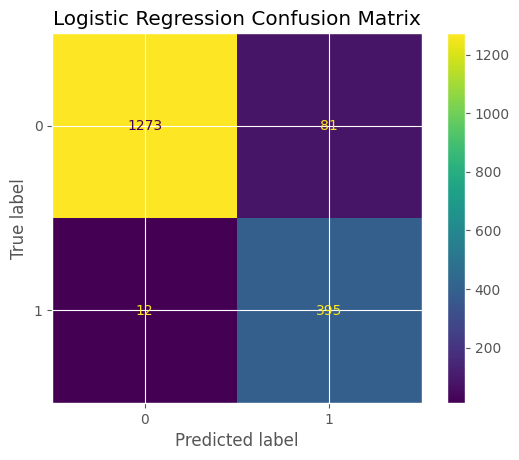

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

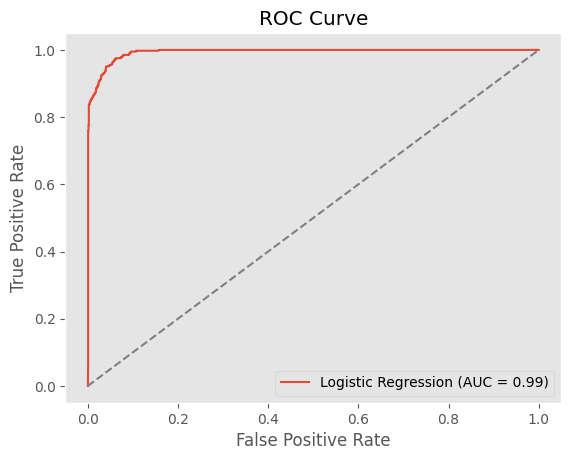

In [74]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = best_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


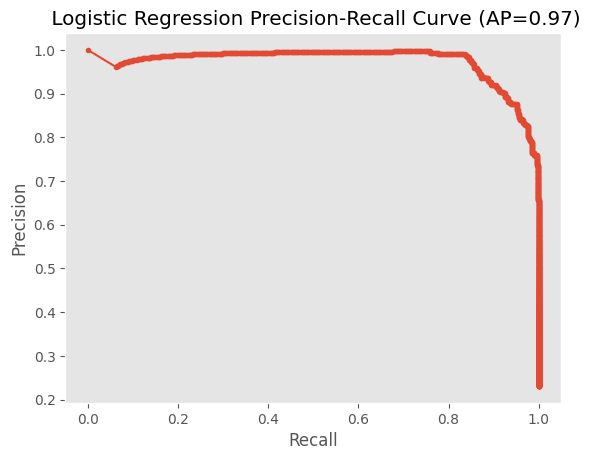

In [75]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_prob = best_lr.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap_score = average_precision_score(y_test, y_prob)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f' Logistic Regression Precision-Recall Curve (AP={ap_score:.2f})')
plt.grid()
plt.show()

In [76]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

dtc = DecisionTreeClassifier()
dtc.fit(X_train_balanced, y_train_balanced)

y_pred = dtc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1354
           1       1.00      1.00      1.00       407

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761



In [77]:
from sklearn.model_selection import cross_val_score

dtc = DecisionTreeClassifier(random_state = 42)
cv_scores = cross_val_score(dtc, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Average CV accuracy:", cv_scores.mean())

Cross-validation scores: [1. 1. 1. 1. 1.]
Average CV accuracy: 1.0


In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid_dtc = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dtc = DecisionTreeClassifier(random_state = 42)

grid = GridSearchCV(dtc, param_grid_dtc, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 1)
grid.fit(X_train_balanced, y_train_balanced)

best_dtc = grid.best_estimator_

y_pred = best_dtc.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1354
           1       1.00      1.00      1.00       407

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761



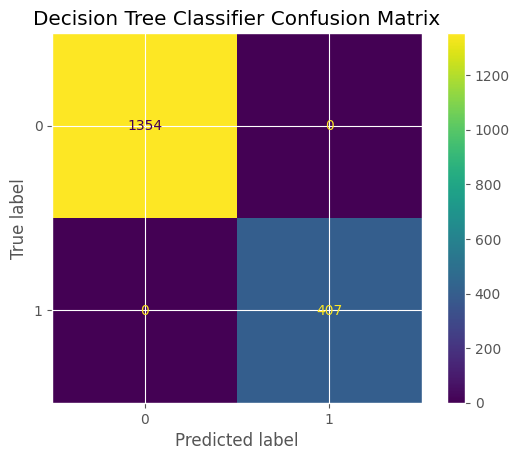

In [79]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(best_dtc, X_test, y_test)
plt.title("Decision Tree Classifier Confusion Matrix")
plt.show()

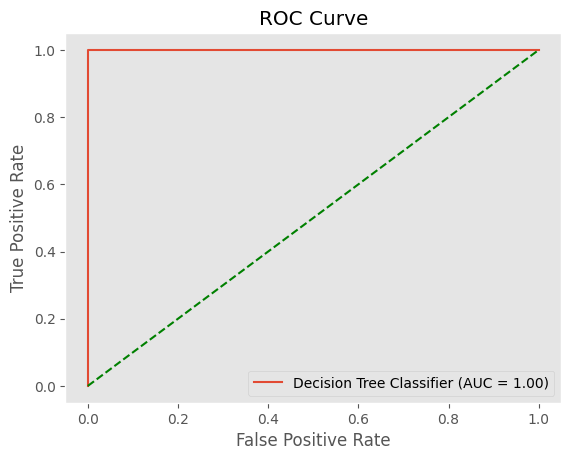

In [80]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = best_dtc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Decision Tree Classifier (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="green")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


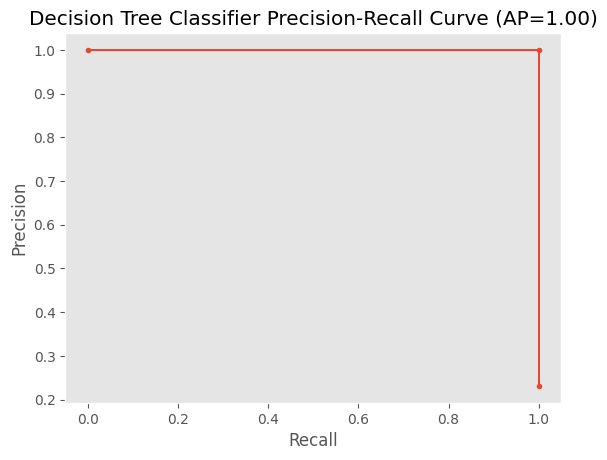

In [81]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_prob = best_dtc.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap_score = average_precision_score(y_test, y_prob)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Decision Tree Classifier Precision-Recall Curve (AP={ap_score:.2f})')
plt.grid()
plt.show()

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(max_depth = 10,class_weight = 'balanced', random_state = 42)
rf.fit(X_train_balanced, y_train_balanced)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9994321408290744
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1354
           1       1.00      1.00      1.00       407

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761



In [83]:
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(random_state = 42)
cv_scores = cross_val_score(rf, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Average CV accuracy:", cv_scores.mean())

Cross-validation scores: [1.         1.         0.99953445 1.         1.        ]
Average CV accuracy: 0.9999068901303538


In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state = 42)

grid = GridSearchCV(rf, param_grid_rf, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 1)
grid.fit(X_train_balanced, y_train_balanced)

best_rf = grid.best_estimator_

y_pred = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Accuracy: 0.9994321408290744
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1354
           1       1.00      1.00      1.00       407

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761



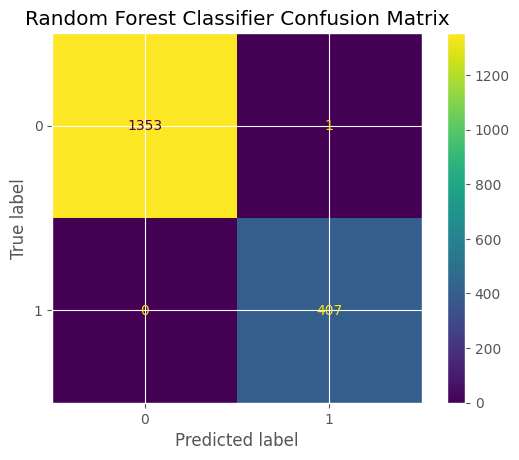

In [85]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Random Forest Classifier Confusion Matrix")
plt.show()

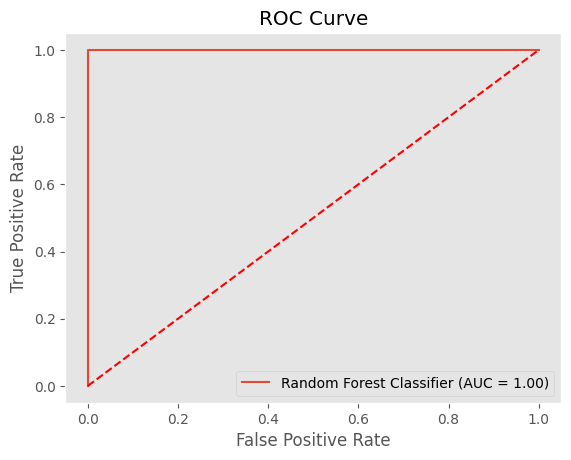

In [86]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Random Forest Classifier (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="red")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


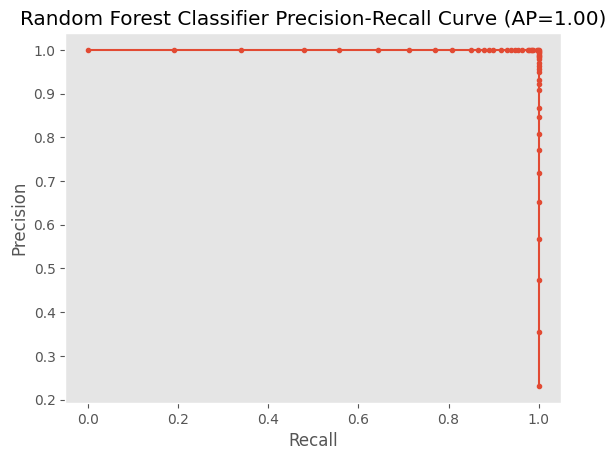

In [87]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_prob = best_rf.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap_score = average_precision_score(y_test, y_prob)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Random Forest Classifier Precision-Recall Curve (AP={ap_score:.2f})')
plt.grid()
plt.show()

In [88]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

knc = KNeighborsClassifier()
knc.fit(X_train_balanced, y_train_balanced)

y_pred = knc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9051675184554231
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1354
           1       0.75      0.89      0.81       407

    accuracy                           0.91      1761
   macro avg       0.86      0.90      0.87      1761
weighted avg       0.92      0.91      0.91      1761



In [89]:
from sklearn.model_selection import cross_val_score

knc = KNeighborsClassifier()
cv_scores = cross_val_score(knc, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Average CV accuracy:", cv_scores.mean())

Cross-validation scores: [0.94040968 0.93994413 0.93761639 0.94457382 0.94923149]
Average CV accuracy: 0.9423551029152453


In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid_knc = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knc = KNeighborsClassifier()

grid = GridSearchCV(knc, param_grid_knc, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 1)
grid.fit(X_train_balanced, y_train_balanced)

best_knc = grid.best_estimator_

y_pred = best_knc.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Accuracy: 0.9341283361726291
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1354
           1       0.88      0.83      0.85       407

    accuracy                           0.93      1761
   macro avg       0.91      0.90      0.91      1761
weighted avg       0.93      0.93      0.93      1761



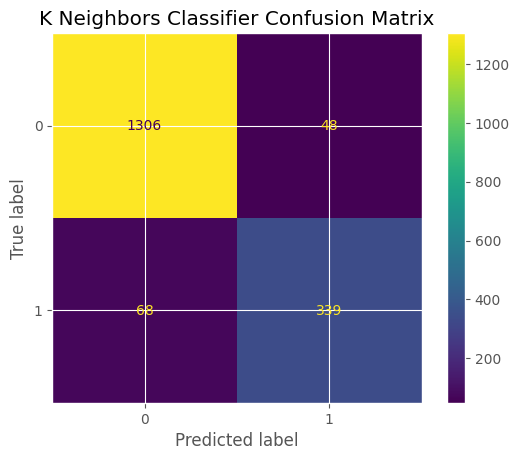

In [91]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(best_knc, X_test, y_test)
plt.title("K Neighbors Classifier Confusion Matrix")
plt.show()

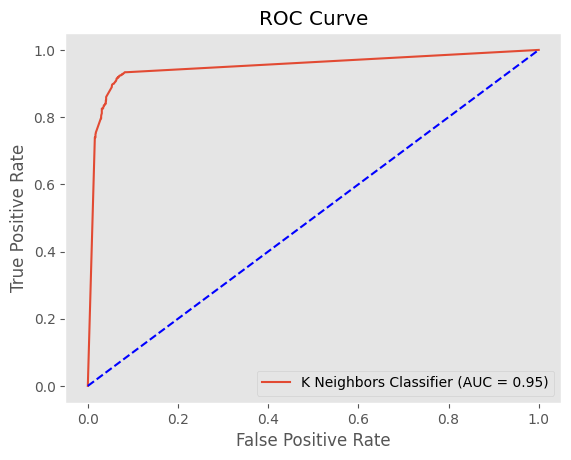

In [92]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = best_knc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"K Neighbors Classifier (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="blue")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


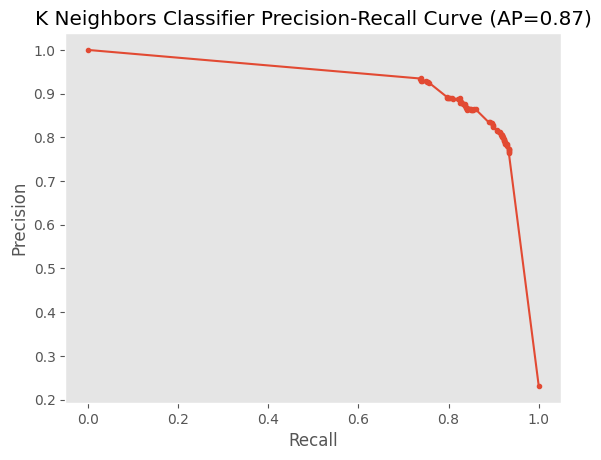

In [93]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_prob = best_knc.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap_score = average_precision_score(y_test, y_prob)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'K Neighbors Classifier Precision-Recall Curve (AP={ap_score:.2f})')
plt.grid()
plt.show()

In [94]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

svc = LinearSVC()
svc.fit(X_train_balanced, y_train_balanced)

y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

c:\Users\Predator-User\Desktop\future_predict\.venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.7773992049971608
Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      1354
           1       0.94      0.04      0.08       407

    accuracy                           0.78      1761
   macro avg       0.86      0.52      0.47      1761
weighted avg       0.81      0.78      0.69      1761



c:\Users\Predator-User\Desktop\future_predict\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [95]:
from sklearn.model_selection import cross_val_score

svc = LinearSVC()
cv_scores = cross_val_score(svc, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Average CV accuracy:", cv_scores.mean())

c:\Users\Predator-User\Desktop\future_predict\.venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Predator-User\Desktop\future_predict\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Predator-User\Desktop\future_predict\.venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Predator-User\Desktop\future_predict\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Predator-User\Desktop\future_predict\.venv\Lib\site-packages\sklearn\

Cross-validation scores: [0.5        0.52700186 0.5009311  0.52771309 0.50023288]
Average CV accuracy: 0.5111757864032702


c:\Users\Predator-User\Desktop\future_predict\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [96]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC

param_dist_svc = {
    'C': [0.1, 1, 10],
    'max_iter': [1000, 2000]
}

svc = LinearSVC(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_dist_svc,
    n_iter=6,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train_balanced, y_train_balanced)

best_svc = random_search.best_estimator_

y_pred = best_svc.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\Predator-User\Desktop\future_predict\.venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.2981260647359455
              precision    recall  f1-score   support

           0       0.96      0.09      0.17      1354
           1       0.25      0.99      0.39       407

    accuracy                           0.30      1761
   macro avg       0.60      0.54      0.28      1761
weighted avg       0.80      0.30      0.22      1761



c:\Users\Predator-User\Desktop\future_predict\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


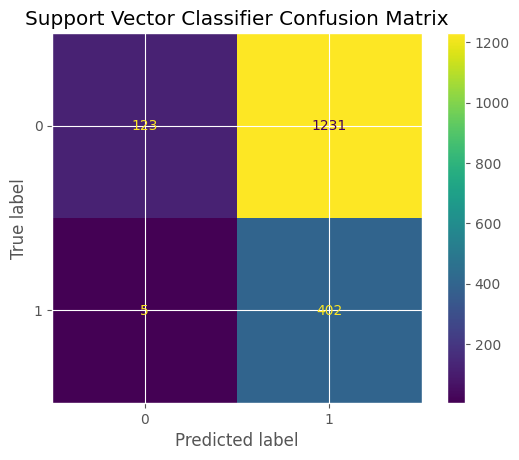

In [97]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(best_svc, X_test, y_test)
plt.title("Support Vector Classifier Confusion Matrix")
plt.show()

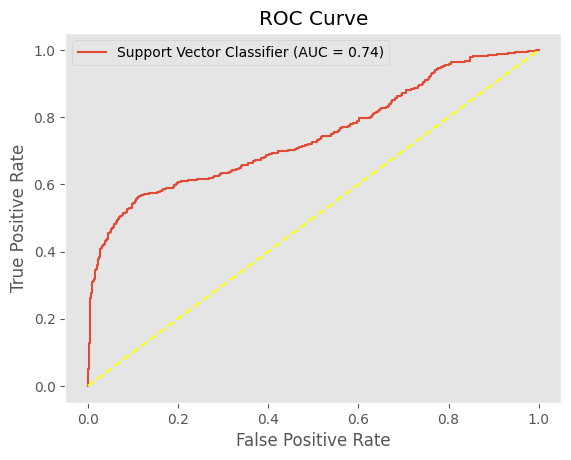

In [98]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_scores = best_svc.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Support Vector Classifier (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="yellow")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


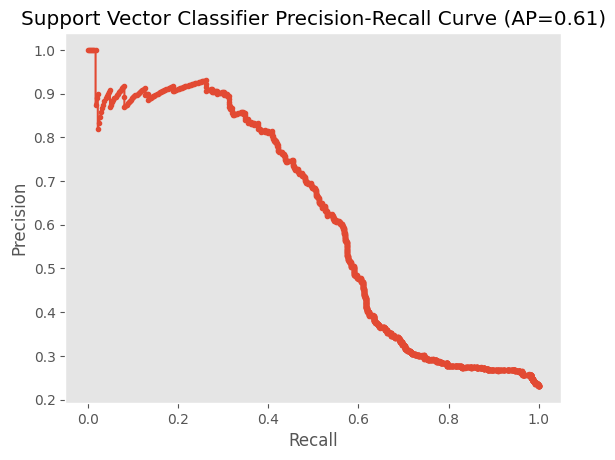

In [99]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_scores = best_svc.decision_function(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
ap_score = average_precision_score(y_test, y_scores)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Support Vector Classifier Precision-Recall Curve (AP={ap_score:.2f})')
plt.grid()
plt.show()

In [100]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = {
    "Logistic Regression": best_lr, 
    "Decision Tree": best_dtc,
    "Random Forest": best_rf,
    "KNN": best_knc,
    "Linear SVC": best_svc,
}

import pandas as pd

results = []

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        y_prob = None

    y_pred = model.predict(X_test)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else 0
    })

comparison_df = pd.DataFrame(results)


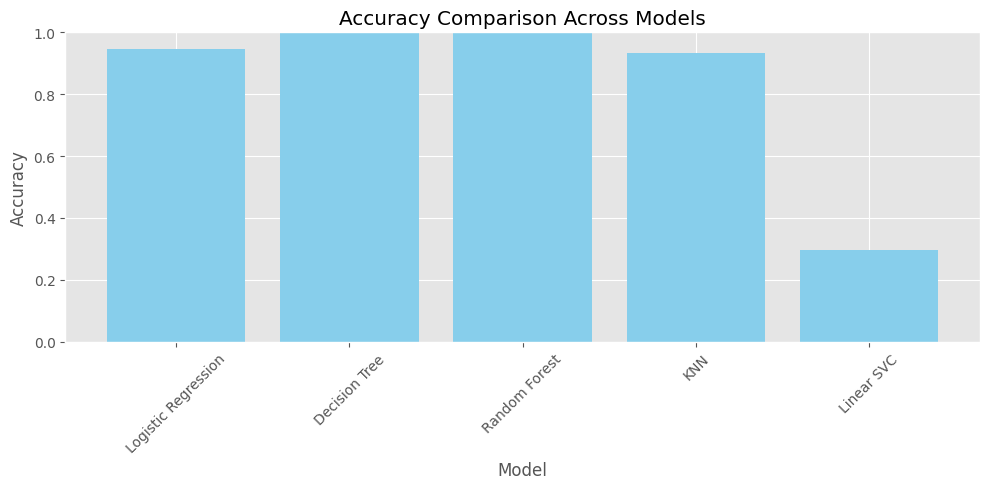

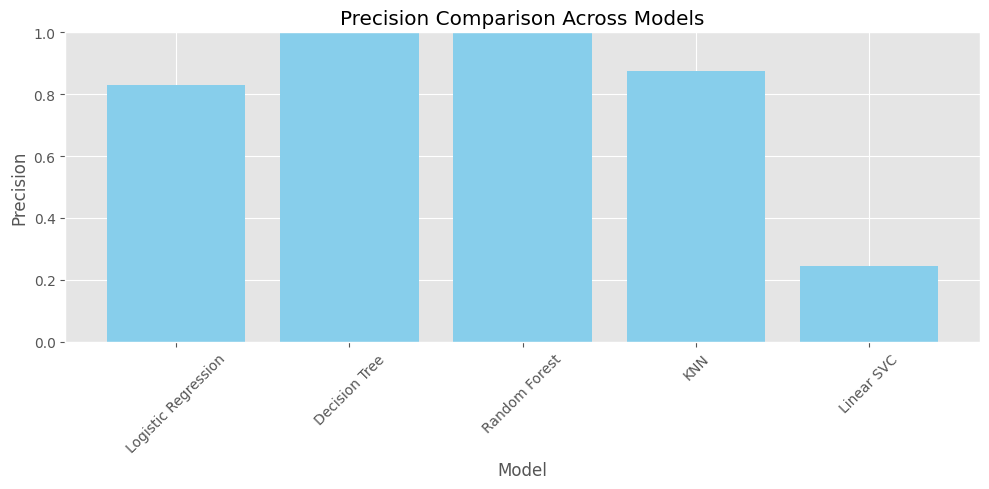

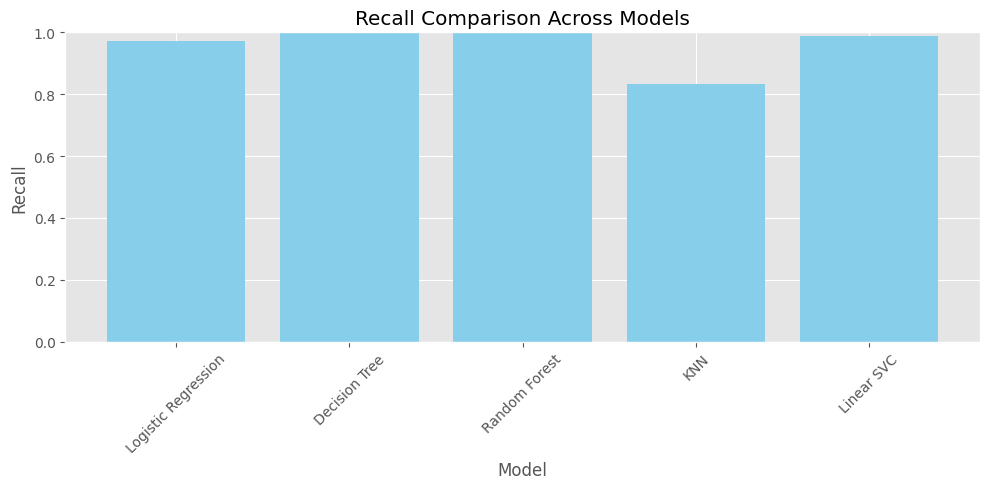

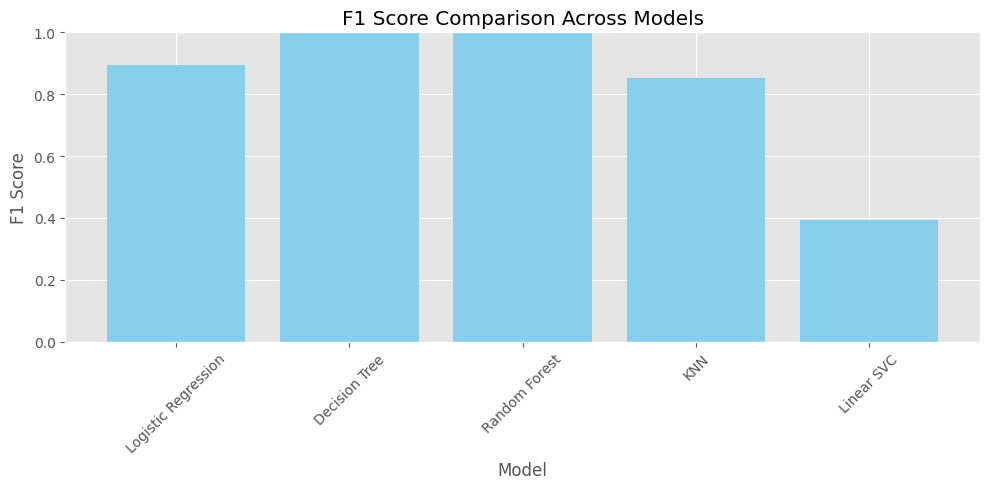

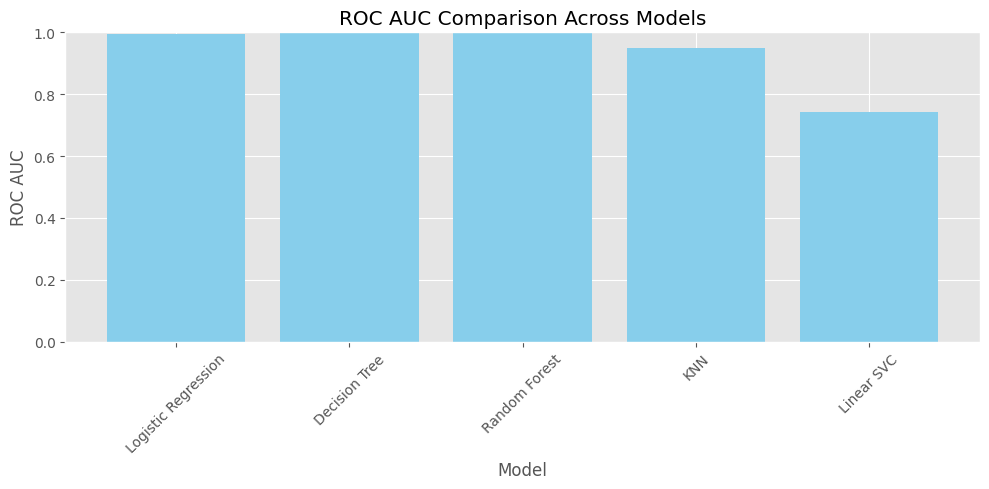

In [101]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]

for metric in metrics:
    plt.figure(figsize=(10, 5))
    plt.bar(comparison_df["Model"], comparison_df[metric], color='skyblue')
    plt.ylim(0, 1)
    plt.title(f"{metric} Comparison Across Models")
    plt.ylabel(metric)
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


               Feature  Coefficient  AbsCoefficient
3         type_encoded    76.694141       76.694141
8            rating_PG    -2.122905        2.122905
19      rating_Unknown    -2.104925        2.104925
7            rating_NR    -0.890944        0.890944
15         rating_TV-Y     0.786104        0.786104
0         duration_num     0.658952        0.658952
16        rating_TV-Y7     0.637435        0.637435
9         rating_PG-13    -0.611329        0.611329
18           rating_UR    -0.511839        0.511839
22        genre_Action     0.377569        0.377569
6         rating_NC-17    -0.317635        0.317635
12         rating_TV-G     0.306802        0.306802
14        rating_TV-PG    -0.291782        0.291782
11        rating_TV-14    -0.275628        0.275628
10            rating_R    -0.259266        0.259266
20         genre_Drama    -0.221579        0.221579
25        genre_Horror    -0.112538        0.112538
13        rating_TV-MA     0.055412        0.055412
4           

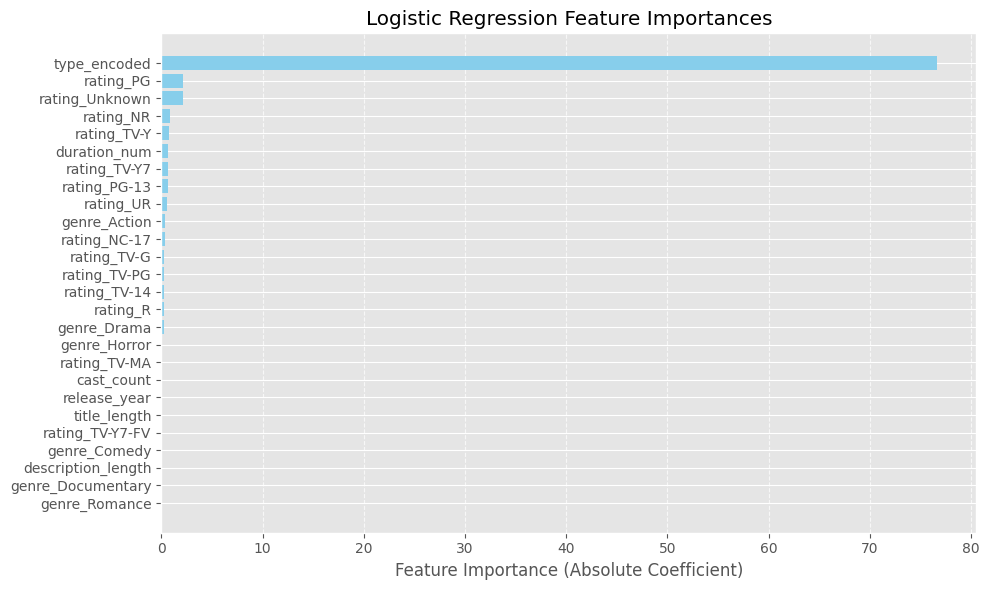

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

feature_names = X_train.columns  
coefficients = best_lr.coef_[0]

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'AbsCoefficient': np.abs(coefficients)
}).sort_values(by='AbsCoefficient', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['AbsCoefficient'], color='skyblue')
plt.xlabel("Feature Importance (Absolute Coefficient)")
plt.title("Logistic Regression Feature Importances")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


               Feature  Importance
0         duration_num    0.727526
3         type_encoded    0.272474
14        rating_TV-PG    0.000000
24       genre_Romance    0.000000
23   genre_Documentary    0.000000
22        genre_Action    0.000000
21        genre_Comedy    0.000000
20         genre_Drama    0.000000
19      rating_Unknown    0.000000
18           rating_UR    0.000000
17     rating_TV-Y7-FV    0.000000
16        rating_TV-Y7    0.000000
15         rating_TV-Y    0.000000
13        rating_TV-MA    0.000000
1   description_length    0.000000
12         rating_TV-G    0.000000
11        rating_TV-14    0.000000
10            rating_R    0.000000
9         rating_PG-13    0.000000
8            rating_PG    0.000000
7            rating_NR    0.000000
6         rating_NC-17    0.000000
5         title_length    0.000000
4           cast_count    0.000000
2         release_year    0.000000
25        genre_Horror    0.000000


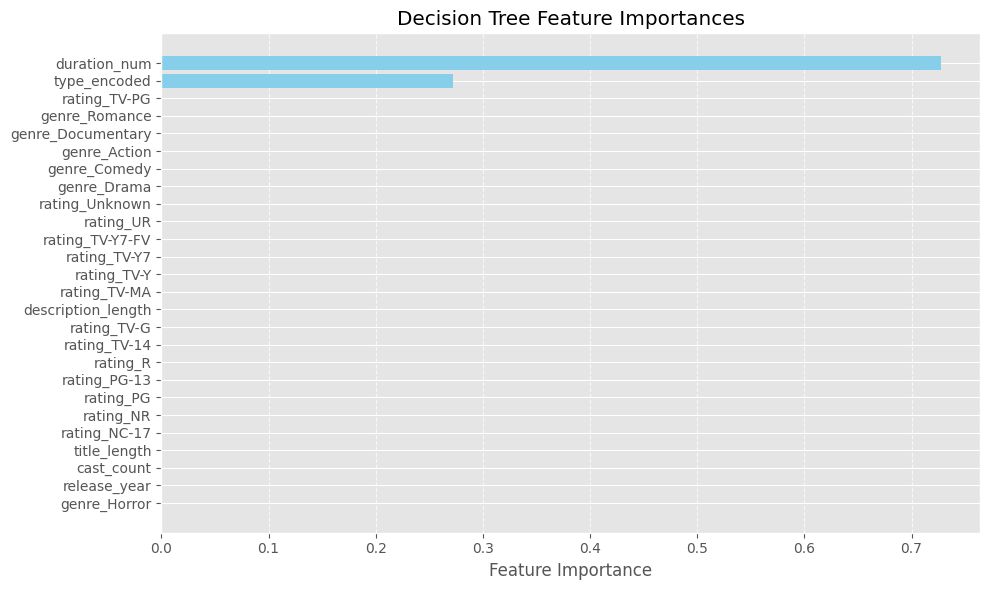

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

importances = best_dtc.feature_importances_

feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Decision Tree Feature Importances")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


               Feature  Importance
0         duration_num    0.751723
3         type_encoded    0.080516
4           cast_count    0.041148
2         release_year    0.028092
5         title_length    0.024053
1   description_length    0.018253
20         genre_Drama    0.015560
11        rating_TV-14    0.009049
22        genre_Action    0.005691
13        rating_TV-MA    0.004116
21        genre_Comedy    0.003972
8            rating_PG    0.003334
10            rating_R    0.002915
16        rating_TV-Y7    0.002708
15         rating_TV-Y    0.002107
14        rating_TV-PG    0.002063
9         rating_PG-13    0.002002
25        genre_Horror    0.001761
12         rating_TV-G    0.000656
7            rating_NR    0.000207
19      rating_Unknown    0.000038
6         rating_NC-17    0.000023
18           rating_UR    0.000008
17     rating_TV-Y7-FV    0.000006
23   genre_Documentary    0.000000
24       genre_Romance    0.000000


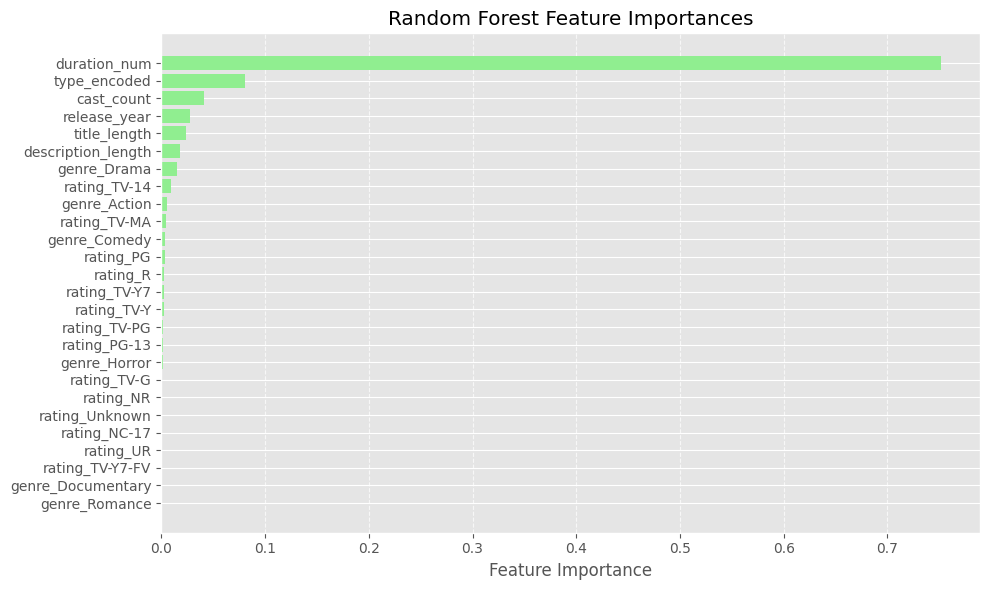

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

feature_names = X_train.columns

importances = best_rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightgreen')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


               Feature  Importance
0         duration_num    0.271437
2         release_year    0.011755
4           cast_count    0.001590
22        genre_Action    0.001193
12         rating_TV-G    0.000454
3         type_encoded    0.000170
5         title_length    0.000170
21        genre_Comedy    0.000114
17     rating_TV-Y7-FV    0.000000
24       genre_Romance    0.000000
23   genre_Documentary    0.000000
19      rating_Unknown    0.000000
18           rating_UR    0.000000
25        genre_Horror    0.000000
10            rating_R    0.000000
8            rating_PG    0.000000
7            rating_NR    0.000000
6         rating_NC-17    0.000000
13        rating_TV-MA   -0.000057
15         rating_TV-Y   -0.000170
9         rating_PG-13   -0.000284
16        rating_TV-Y7   -0.000681
20         genre_Drama   -0.000852
14        rating_TV-PG   -0.000965
11        rating_TV-14   -0.001647
1   description_length   -0.003180


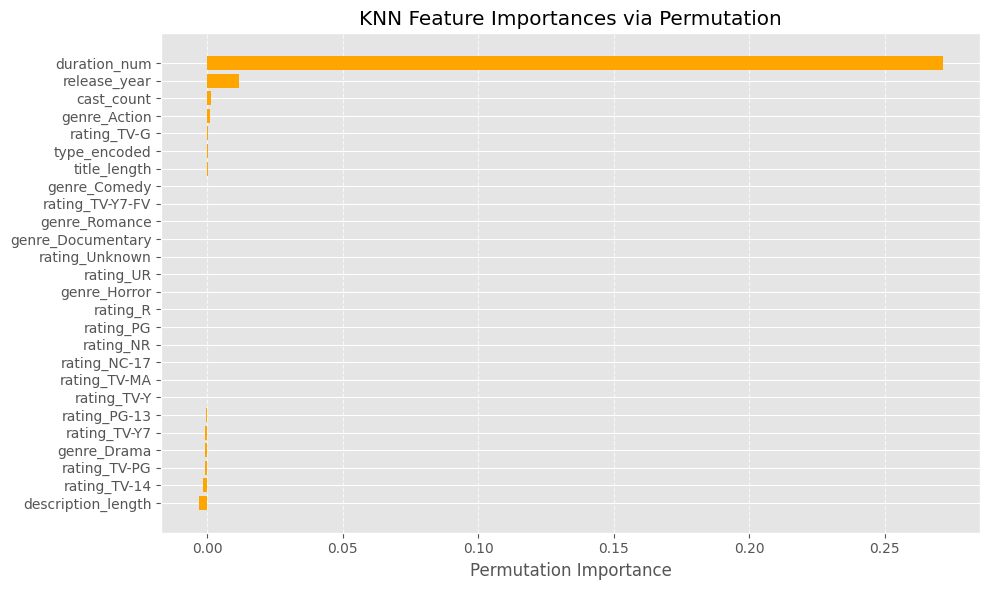

In [105]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

result = permutation_importance(best_knc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='orange')
plt.xlabel("Permutation Importance")
plt.title("KNN Feature Importances via Permutation")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


               Feature  Coefficient
3         type_encoded     0.322718
11        rating_TV-14     0.103782
20         genre_Drama     0.093849
22        genre_Action     0.054533
8            rating_PG    -0.045900
10            rating_R    -0.042449
25        genre_Horror    -0.032369
16        rating_TV-Y7     0.031104
21        genre_Comedy    -0.029114
15         rating_TV-Y     0.028654
13        rating_TV-MA    -0.026320
4           cast_count     0.025595
12         rating_TV-G     0.025039
9         rating_PG-13    -0.020003
14        rating_TV-PG    -0.019446
7            rating_NR    -0.006263
0         duration_num     0.005297
5         title_length    -0.004361
1   description_length     0.004269
19      rating_Unknown    -0.000829
17     rating_TV-Y7-FV    -0.000656
18           rating_UR    -0.000503
2         release_year    -0.000417
6         rating_NC-17    -0.000049
23   genre_Documentary     0.000000
24       genre_Romance     0.000000


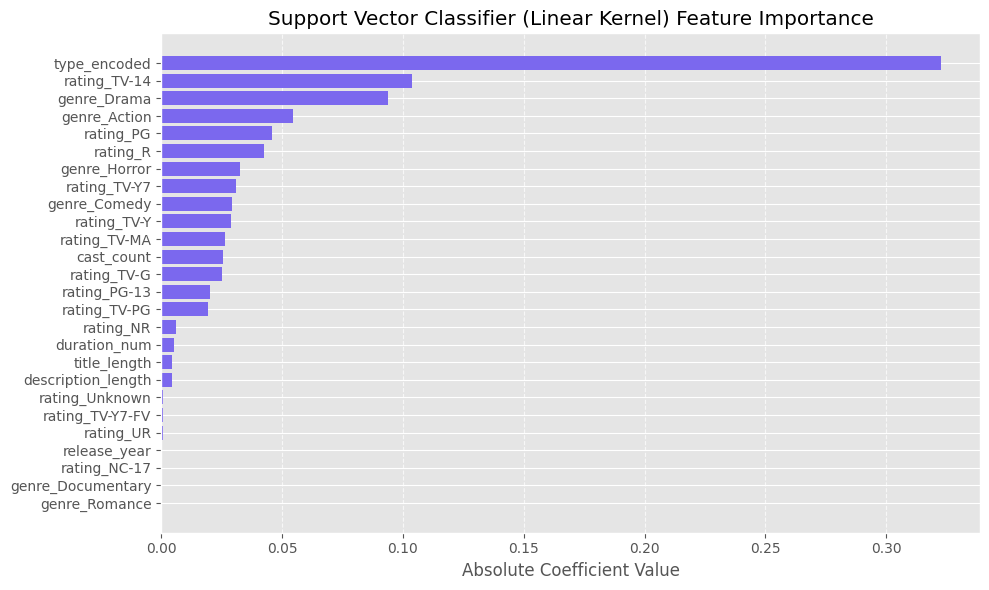

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

feature_names = X_train.columns

coefficients = best_svc.coef_[0]

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'AbsCoefficient': np.abs(coefficients)
}).sort_values(by='AbsCoefficient', ascending=False)

print(importance_df[['Feature', 'Coefficient']])

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['AbsCoefficient'], color='mediumslateblue')
plt.xlabel("Absolute Coefficient Value")
plt.title("Support Vector Classifier (Linear Kernel) Feature Importance")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


                                    Title  Predicted_Popularity  Probability
2863                  There Will Be Blood                     1          1.0
1958                        The Chef Show                     1          1.0
3195                               Jindua                     1          1.0
1965  High & Low The Movie 2 / End of Sky                     1          1.0
7565        Natsamrat - Asa Nat Hone Nahi                     1          1.0
3562                            HERO MASK                     1          1.0
3563                       Kaake Da Viyah                     1          1.0
3564                      Marriage Palace                     1          1.0
7574             Nature's Weirdest Events                     1          1.0
7576                    Nazi Mega Weapons                     1          1.0

Most Likely Popular Title:
Title                   There Will Be Blood
Predicted_Popularity                      1
Probability                          

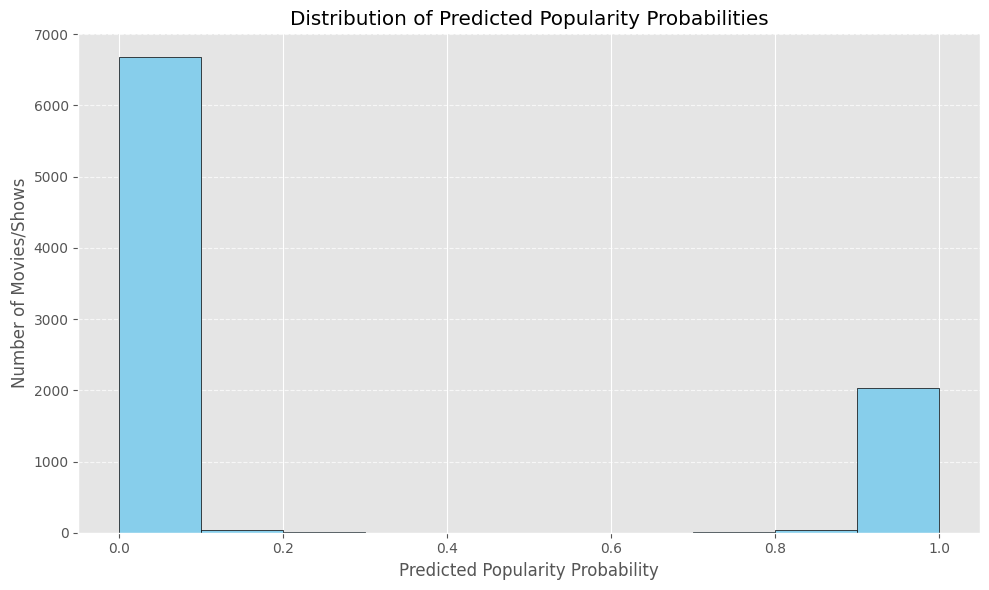

In [107]:
import matplotlib.pyplot as plt

trained_feature_cols = X.columns.tolist()

def predict_popular_titles(df_full, model, trained_feature_cols):
    titles = df_full["title"]

    X_input = df_full.copy()

    for col in trained_feature_cols:
        if col not in X_input.columns:
            X_input[col] = 0 

    X_input = X_input[trained_feature_cols]

    preds = model.predict(X_input)
    probs = model.predict_proba(X_input)[:, 1]

    results_df = pd.DataFrame({
        'Title': titles,
        'Predicted_Popularity': preds,
        'Probability': probs
    }).sort_values(by='Probability', ascending=False)

    return results_df

results = predict_popular_titles(df, best_rf, trained_feature_cols)
print(results.head(10))
print("\nMost Likely Popular Title:")
print(results.iloc[0])

plt.figure(figsize=(10, 6))
plt.hist(results['Probability'], bins=10, edgecolor='black', color='skyblue')
plt.xlabel('Predicted Popularity Probability')
plt.ylabel('Number of Movies/Shows')
plt.title('Distribution of Predicted Popularity Probabilities')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
